In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

### csv 파일에서 로드하고 결측치 확인

In [2]:
gold = pd.read_csv('Gold.csv', index_col='Date')
gold.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
"Apr 17, 2020",1698.8,1738.5,1738.8,1691.2,-,-1.90
"Apr 16, 2020",1731.7,1743.5,1768.0,1722.6,204.23K,-0.49
"Apr 15, 2020",1740.2,1758.1,1759.8,1731.6,-,-1.62
"Apr 14, 2020",1768.9,1761.5,1788.8,1747.1,-,0.43
"Apr 13, 2020",1761.4,1742.3,1772.8,1724.2,-,1.19


In [3]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2676 entries, Apr 17, 2020 to Jan 04, 2010
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2676 non-null   float64
 1   Open    2676 non-null   float64
 2   High    2676 non-null   float64
 3   Low     2676 non-null   float64
 4   Volume  2676 non-null   object 
 5   Change  2676 non-null   float64
dtypes: float64(5), object(1)
memory usage: 146.3+ KB


### 데이터 순서 재배치, 플롯 확인, 인덱스 배치

In [4]:
gold = gold.loc[::-1] # 밑에서 부터 보기(과거부터 현재 순)

<AxesSubplot:xlabel='Date'>

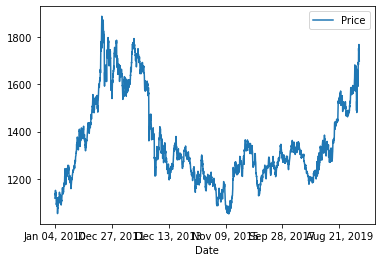

In [5]:
gold[['Price']].plot()


In [6]:
price = gold[['Price']]

In [7]:
price = price.reset_index(drop=True) 

In [8]:
len(price)

2676

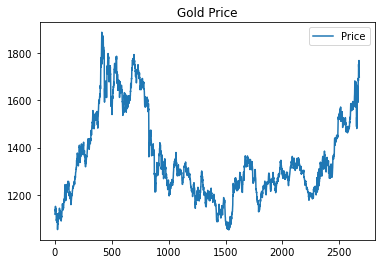

In [9]:
price.plot()
plt.title('Gold Price')
plt.show()

### 학습/검증 구간 분리

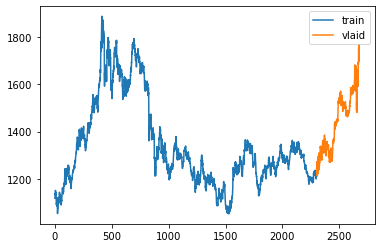

In [10]:
split = 2300
train = price.loc[:split, ["Price"]]
test = price.loc[split:, ["Price"]]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'vlaid'])

### 스케일링 (0 ~1) 된 df 만들기

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

sc_train = sc.fit_transform(train)
sc_test = sc.transform(test)

train = pd.DataFrame(sc_train, columns=['price'], index=train.index)
test = pd.DataFrame(sc_test, columns=['price'], index=test.index)
train.head()

,price
0,0.079842
1,0.080320
2,0.101563
3,0.098222
4,0.104308


### df 에서 shift 함수 사용해 바로 윈도우 적용

In [12]:
windowsize = 20
for s in range(windowsize):
    train['shift_{}'.format(s)] = train['price'].shift(s)
    test['shift_{}'.format(s)] = test['price'].shift(s)

train.head()

,price,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,...,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19
0,0.079842,0.079842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.080320,0.080320,0.079842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.101563,0.101563,0.080320,0.079842,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.098222,0.098222,0.101563,0.080320,0.079842,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.104308,0.104308,0.098222,0.101563,0.080320,0.079842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Df에서 values로 ndarray로 빼내오기

In [13]:
x_train = train.dropna().drop('price', axis=1).values
y_train = train.dropna()[['price']].values

x_test = test.dropna().drop('price', axis=1).values
y_test = test.dropna()[['price']].values

print(x_train.shape)
print(y_train.shape)

(2282, 20)
(2282, 1)


### lstm 모델에 넣도록 reshape

In [14]:
# batch_size * length * series demension
x_train = x_train.reshape(x_train.shape[0], windowsize, 1)
x_test = x_test.reshape(x_test.shape[0], windowsize, 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2282, 20, 1)
(2282, 1)
(357, 20, 1)
(357, 1)


In [15]:
import os 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

### 파이토치 모델에 넣도록 텐서화

In [16]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

# Params

In [17]:
seed = 1

lr = 0.001
momentum = 0.5

batch_size = 64
test_batch_size = 64

epochs = 10
no_cuda = False
log_interval = 100

# Model (클래스 정의)

In [18]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers=2):
        super(Net, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1]) 
        return x
        

In [19]:
input_dim = x_train.shape[-1]
hidden_dim = 64
output_dim = y_train.shape[-1]
lr = 1e-3
epochs = 100

# Optim (모델 계산할 위치와 최적화 조건 설정)

In [20]:
model = Net(input_dim, hidden_dim, output_dim, 2)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training & Validation

In [21]:
hist = []
test_hist = []
for t in range(epochs):
    # Train Mode
    model.train()

    # 예측 및 로스 계산
    output = model(x_train)
    loss = criterion(output, y_train)  

    # 개선
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    hist.append(loss)
   
        
    # Test mode
    model.eval()
    
    test_loss = 0
    
    with torch.no_grad():
        result = model(x_test)
        test_loss += criterion(result, y_test)
        test_hist.append(test_loss)
    
    if t % 10 == 0:
        print('Train Epoch: {} \tLoss: {:.4f},Testloss: {:.4f}'.format(t, 
                                            loss.item(), test_loss.item()))
     

Train Epoch: 0 	Loss: 0.1718,Testloss: 0.2318
Train Epoch: 10 	Loss: 0.0455,Testloss: 0.0292
Train Epoch: 20 	Loss: 0.0383,Testloss: 0.0335
Train Epoch: 30 	Loss: 0.0291,Testloss: 0.0198
Train Epoch: 40 	Loss: 0.0095,Testloss: 0.0079
Train Epoch: 50 	Loss: 0.0070,Testloss: 0.0110
Train Epoch: 60 	Loss: 0.0039,Testloss: 0.0039
Train Epoch: 70 	Loss: 0.0035,Testloss: 0.0036
Train Epoch: 80 	Loss: 0.0029,Testloss: 0.0040
Train Epoch: 90 	Loss: 0.0024,Testloss: 0.0027


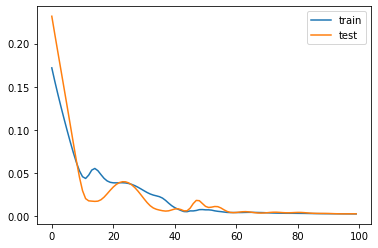

In [22]:
plt.plot(hist, label = 'train')
plt.plot(test_hist, label='test')
plt.legend()
plt.show()

## 예측 결과 시각화

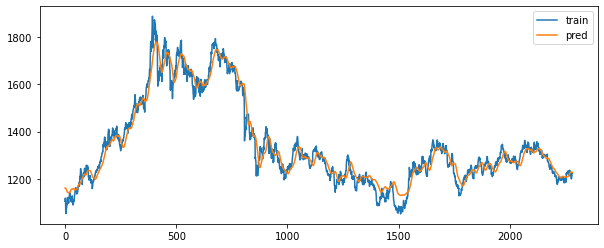

In [23]:
# 스케일링 역변환
train_results = sc.inverse_transform(torch.detach(output).numpy())
train = sc.inverse_transform(np.array(y_train))

plt.figure(figsize=(10, 4))

plt.plot(train, label='train')
plt.plot(train_results, label='pred')
plt.legend()

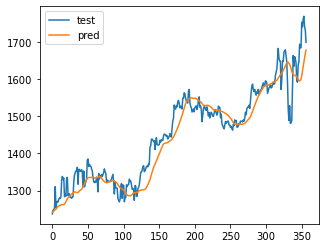

In [24]:
# 스케일링 역변환
results = sc.inverse_transform(np.array(result))
test = sc.inverse_transform(np.array(y_test))

plt.figure(figsize=(5, 4))

plt.plot(test, label='test')
plt.plot(results, label='pred')
plt.legend()

# Save Model & tensor board (굳이..)